In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import gc
import gzip
import os
import warnings
import random
import graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from bayes_opt import BayesianOptimization
from graphviz import Digraph

%matplotlib inline

# 读入数据

In [3]:
df = pd.read_csv("./merge_result.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21541 entries, 0 to 21540
Columns: 176 entries, companyName to entertainment_rp
dtypes: float64(167), int64(1), object(8)
memory usage: 28.9+ MB
None


## 做一些简单的处理

In [4]:
# 删除 target 为 null 的数据
df = df.loc[df['is_defunct'].notnull()]  # print(df['is_defunct'].isnull().sum())
print(df.shape)

(19591, 176)


In [5]:
# 有几个不同的公司
len(df['companyName'].unique())

348

In [6]:
# 其中破产公司有几个
len(df.loc[df['is_defunct']==1]['companyName'].unique())

15

In [7]:
# 其中正常公司有几个
len(df.loc[df['is_defunct']==0]['companyName'].unique())

333

In [8]:
# 后面还要删除一些列！

# 第一次train model

## 划分train、test

In [10]:
# y = df['is_defunct']
# df = df.drop(columns=['is_defunct'])   #X  print(df.info()) ok

### monarch, wow 2家公司必须作为 test，也作为唯二的test

In [11]:
test = df.loc[(df['companyName']=='Monarch [no longer operating]') | (df['companyName']=='WOW air [no longer operating]')]
y_test = test['is_defunct']
X_test = test.drop(columns=['is_defunct'])
display(X_test)  # 129条样本

,companyName,DOW,cabin_nunique,LR_min,LR_max,LR_mean,LR_std,LR_median,SC_min,SC_max,...,max_accident_date,max_fatalities,total_fatalities,accident_cnt,review_count_rp,rating_rp,cabin_crew_rp,meal_rp,comfort_rp,entertainment_rp
12744,Monarch [no longer operating],2017-01,1.0,2.0,5.0,3.964286,0.961563,4.0,2.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6
12745,Monarch [no longer operating],2017-02,1.0,1.0,5.0,3.674419,1.209505,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6
12746,Monarch [no longer operating],2017-03,1.0,1.0,5.0,3.980392,1.009756,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6
12747,Monarch [no longer operating],2017-04,1.0,1.0,5.0,3.744186,1.177023,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6
12748,Monarch [no longer operating],2017-05,1.0,1.0,5.0,3.727273,1.364895,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6
12749,Monarch [no longer operating],2017-06,1.0,1.0,5.0,3.735211,1.168211,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6
12750,Monarch [no longer operating],2017-07,1.0,1.0,5.0,3.622222,1.268262,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6
12751,Monarch [no longer operating],2017-08,1.0,1.0,5.0,3.639138,1.146206,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6
12752,Monarch [no longer operating],2017-09,1.0,1.0,5.0,3.673077,1.029647,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6
12753,Monarch [no longer operating],2017-10,1.0,1.0,5.0,3.461538,1.613246,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,5.0,6.9,9.5,-99.0,7.7,2.6


### 其他样本统一作为 train

In [12]:
train = df.loc[(df['companyName']!='Monarch [no longer operating]') & (df['companyName']!='WOW air [no longer operating]')]
y_train = train['is_defunct']
X_train = train.drop(columns=['is_defunct'])
display(X_train)  # 19462 条样本

,companyName,DOW,cabin_nunique,LR_min,LR_max,LR_mean,LR_std,LR_median,SC_min,SC_max,...,max_accident_date,max_fatalities,total_fatalities,accident_cnt,review_count_rp,rating_rp,cabin_crew_rp,meal_rp,comfort_rp,entertainment_rp
0,ANA (All Nippon Airways),2019-06,2.0,3.0,5.0,4.250000,0.930949,5.0,2.0,5.0,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,ANA (All Nippon Airways),2019-07,3.0,1.0,5.0,4.285714,1.053850,5.0,1.0,5.0,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,ANA (All Nippon Airways),2009-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,ANA (All Nippon Airways),2009-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ANA (All Nippon Airways),2009-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,ANA (All Nippon Airways),2009-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
6,ANA (All Nippon Airways),2010-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7,ANA (All Nippon Airways),2010-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,ANA (All Nippon Airways),2010-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,ANA (All Nippon Airways),2010-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


### train、test 的情况（删除一列Variable）

In [13]:
# 删除一些列
del_cols = ['companyName', 'DOW', 'country_code', 'busn_name', 'cust_id_concatenate', 'airline_tagging', 'country', 'max_accident_date']
X_test = X_test.drop(columns=del_cols)
X_train = X_train.drop(columns=del_cols)

In [14]:
print(X_train.shape)

(19462, 167)


In [15]:
print(X_test.shape)

(129, 167)


## 调整model超参数

In [16]:
def LGB_CV( # 原版
    max_depth,
    num_leaves,
    min_data_in_leaf,
    feature_fraction,
    bagging_fraction,
    lambda_l1,
#     train,
#     target
):
    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(X_train.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(X_train.iloc[trn_idx][:],
                               label=y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx][:],
                               label=y_train.iloc[val_idx])
    
        param = {
            "boosting": "gbdt",
            'objective':'binary',
            'metric': 'binary_logloss',
            'learning_rate': 0.01,
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'max_depth': int(max_depth),                        
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,  #int(bagging_freq),   #1
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "lambda_l1": lambda_l1,
            "verbosity": -1,        
        }
    
        clf = lgb.train(param,
                        trn_data,
                        6000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=200,
                        early_stopping_rounds = 500)
        
        oof[val_idx] = clf.predict(X_train.iloc[val_idx][:], num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    return -log_loss(y_train, oof) #最小化log_loss，所以添加负号

In [17]:
LGB_BO = BayesianOptimization(
    LGB_CV, {
        'max_depth': (4, 10),
        'num_leaves': (30, 300),
        'min_data_in_leaf': (10, 2000),
        'feature_fraction': (0.5, 1.0),
        'bagging_fraction': (0.7, 1.0),
        'lambda_l1': (3, 9),
#         'train': X_train,
#         'target': y_train
})

In [18]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)
# 运行 

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.100729	valid_1's binary_logloss: 0.107326
[400]	training's binary_logloss: 0.0625155	valid_1's binary_logloss: 0.0661864
[600]	training's binary_logloss: 0.0402319	valid_1's binary_logloss: 0.0430796
[800]	training's binary_logloss: 0.0275571	valid_1's binary_logloss: 0.0300049
[1000]	training's binary_logloss: 0.020109	valid_1's binary_logloss: 0.0223005
[1200]	training's binary_logloss: 0.0154796	valid_1's binary_logloss: 0.0174517
[1400]	training's binary_logloss: 0.0125058	valid_1's binary_logloss: 0.0142651
[1600]	training's binary_logloss: 0.0105259	valid_1's binary_logloss: 0.0120861
[1800]	training's binary_logloss: 0.00917357	valid_1's binary_logloss: 0.0106213
[2000]	training's 

KeyboardInterrupt: 

In [ ]:
print('Final Results')
print('Maximum value: %f' % LGB_BO.max['target'])
print('Best parameters: ', LGB_BO.max['params'])

## 训练model 并预测

In [ ]:
# ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def draw_ROC_curve(y_test,y_predict,savepath=None):
    '''
    画ROC曲线
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    if savepath:
        plt.savefig(savepath)
    plt.close(0)

In [ ]:
param = {
    "boosting": "gbdt",
    'objective':'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.01,
    'num_leaves': 11,
    'min_data_in_leaf': 118, 
    'max_depth': 10,                        
    "feature_fraction": 0.80279441778009675,
    "bagging_freq": 1,  #int(bagging_freq),   #1
    "bagging_fraction": 0.94918097174380245 ,
    "bagging_seed": 11,
    "lambda_l1": 3.0031581969835157,
    "verbosity": -1,        
}

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][:],
                           label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][:],
                           label=y_train.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][:], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

In [ ]:
print(oof)

### 画出train的ROC曲线、AUC值

In [ ]:
# ROC
%matplotlib inline

draw_ROC_curve(y_train, oof, savepath='1_overfit_train_ROC.png')
# draw_ROC_curve(y_test, predictions)

### 观察测试集

In [ ]:
display(np.max(predictions))
display(np.min(predictions))

# 重新调整model

## 重新划分 train、test，使其中的target的分布相似

In [9]:
df['is_defunct'].value_counts()  #94.1% 的样本是负样本，只有5.88% 的样本是正样本

0.0    18439
1.0     1152
Name: is_defunct, dtype: int64

In [10]:
# Monarch、WOW 是必须要作为 test 中的负样本的! 还要从其他样本中挑出一部分正样本、一部分负样本来添加到 test 中！
tmp1 = df.loc[(df['companyName']=='Monarch [no longer operating]') | (df['companyName']=='WOW air [no longer operating]')]
tmp1.shape

(129, 176)

### test 的大小一般为2000个左右
* 其中应该大约有118个正样本，1882个负样本
* 那么只增加负样本的公司就行
* 按公司来划分，test：3家破产+61家正常；train：12家破产+267家正常；
* test 中3家破产: ['Primera Air [no longer operating]', 'Monarch [no longer operating]', 'WOW air [no longer operating]']
* test 中66家正常: ['Air France', 'Virgin Australia', 'Viva Aerobus', 'Central Mountain Air', 'Juneyao Airlines', 'Ural Airlines', 'Corendon Airlines', 'Jeju Air', 'Royal Air Maroc', 'Vanilla Air', 'Kuwait Airways', 'Philippine Airlines (PAL)', 'TAME Vuela Ecuador', 'Pobeda', 'SmartWings', 'Thomas Cook Airlines Scandinavia', 'Ukraine International Airlines', 'Cayman Airways', 'Croatia Airlines', 'Kulula', 'Beijing Capital Airlines', 'China Eastern Airlines', 'QAZAQ AIR', 'Jetstar Japan',  'Silver Airways', 'Tajik Air', 'Boliviana de Aviacion', 'Mauritania Airlines', 'Myanmar National Airlines', 'AirAsia - Philippines AirAsia', 'Interjet', 'Myanmar Airways International', 'Wamos Air', 'Andes Lineas Aereas', 'Air Panama', 'TUIfly (Germany)', 'Royal Jordanian', 'Lufthansa', 'Norwegian', 'Virgin Atlantic Airways', 'Mann Yadanarpon Airlines', 'Kan Airlines', 'Sudan Airways', 'Viva Air (Colombia)', 'Biman Bangladesh Airlines', 'China Southern Airlines', 'Flynas', 'SriLankan Airlines', 'Sun Country Airlines', 'Nordica', 'AnadoluJet', 'Thai Lion Air', 'Flyadeal', 'Jin Air'] 'Royal Brunei Airlines', 'PAWA Dominicana [no longer operating]', 'InselAir', 'Bassaka Air', 'Alliance Airlines', 'SANSA', 'Evelop', 'China Airlines', 'Luxair', 'ANA (All Nippon Airways)', 'Air Vanuatu', 'ATA Airlines (Iran)' 

*'tigerair australia', 'Air Madagascar', 'Southwest Airlines', 'Nouvel Air Tunise', 'TAROM', 'Wings Air', 'British Airways'

In [11]:
# 挑选 test 中破产的公司 =1
df.loc[df['is_defunct']==1]['companyName'].unique()

array(['Air New Zealand', 'Airlink', 'Avianca', 'Fiji Airways',
       'Garuda Indonesia', 'Gulf Air', 'Icelandair',
       'LAN Airlines (now LATAM Airlines)', 'LATAM Airlines', 'LIAT',
       'Monarch [no longer operating]',
       'Primera Air [no longer operating]', 'Regional Air',
       'WOW air [no longer operating]', nan], dtype=object)

In [12]:
random.sample(list(df.loc[df['is_defunct']==1]['companyName'].unique()), 1)

['LIAT']

In [13]:
df.loc[df['companyName']=='Primera Air [no longer operating]'] #108个样本

,companyName,DOW,cabin_nunique,LR_min,LR_max,LR_mean,LR_std,LR_median,SC_min,SC_max,...,max_accident_date,max_fatalities,total_fatalities,accident_cnt,review_count_rp,rating_rp,cabin_crew_rp,meal_rp,comfort_rp,entertainment_rp
14539,Primera Air [no longer operating],2016-02,1.0,3.0,3.0,3.000000,NaN,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0
14540,Primera Air [no longer operating],2016-05,1.0,5.0,5.0,5.000000,NaN,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0
14541,Primera Air [no longer operating],2016-06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0
14542,Primera Air [no longer operating],2016-07,1.0,1.0,5.0,2.625000,1.505941,3.0,1.0,4.0,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0
14543,Primera Air [no longer operating],2016-08,1.0,1.0,4.0,2.727273,0.904534,3.0,1.0,4.0,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0
14544,Primera Air [no longer operating],2016-09,1.0,2.0,5.0,3.700000,0.823273,4.0,2.0,5.0,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0
14545,Primera Air [no longer operating],2016-10,1.0,3.0,4.0,3.333333,0.577350,3.0,2.0,4.0,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0
14546,Primera Air [no longer operating],2016-11,1.0,2.0,3.0,2.500000,0.707107,2.5,2.0,3.0,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0
14547,Primera Air [no longer operating],2016-12,1.0,1.0,1.0,1.000000,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0
14548,Primera Air [no longer operating],2017-01,1.0,1.0,3.0,2.250000,0.957427,2.5,1.0,3.0,...,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,5.0,5.0


In [14]:
# 挑选 test 中正常的公司 =0
df.loc[df['is_defunct']==0]['companyName'].unique()

array(['ANA (All Nippon Airways)', 'ASKY Airlines', 'ATA Airlines (Iran)',
       'Air Canada Rouge', 'Air Caraibes', 'Air China', 'Air Corsica',
       'Air Costa (no longer operating)', 'Air Dolomiti', 'Air Europa',
       'Air France', 'Air Greenland', 'Air India', 'Air India Express',
       'Air Italy', 'Air KBZ', 'Air Macau', 'Air Madagascar', 'Air Malta',
       'Air Mauritius', 'Air Moldova', 'Air Namibia', 'Air Niugini',
       'Air North (Canada)', 'Air Nostrum', 'Air Panama',
       'Air Pegasus (no longer operating)', 'Air Rarotonga', 'Air Serbia',
       'Air Seychelles', 'Air Tahiti Nui', 'Air Transat', 'Air Vanuatu',
       'Air Zimbabwe', 'AirAsia - AirAsia Berhad (Malaysia)',
       'AirAsia - AirAsia India', 'AirAsia - AirAsia X Berhad (Malaysia)',
       'AirAsia - Philippines AirAsia', 'AirAsia - Thai AirAsia',
       'AirSWIFT', 'Airblue', 'Alaska Airlines', 'Alitalia',
       'Allegiant Air', 'Alliance Airlines', 'AnadoluJet',
       'Andes Lineas Aereas', 'Ariana

In [15]:
random.sample(list(df.loc[df['is_defunct']==0]['companyName'].unique()), 66)

['Korean Air',
 'Vueling Airlines',
 'Air Zimbabwe',
 'Hawaiian Airlines',
 'Ethiopian Airlines',
 'Solomon Airlines',
 'Surinam Airways',
 'Mandarin Airlines',
 'Finnair',
 'Arik Air',
 'Far Eastern Air Transport',
 'Asiana Airlines',
 'Olympic Air [NOT the same as Olympus Airways]',
 'Passaredo Linhas Aereas',
 'El Al Israel Airlines',
 'Montenegro Airlines',
 'DAT Danish Air Transport',
 'Avior Airlines',
 'Nextjet [no longer operating]',
 'Silver Airways',
 'Royal Air Maroc',
 'Germanwings',
 'Kuwait Airways',
 'PAWA Dominicana [no longer operating]',
 'BH Air',
 'AirAsia - AirAsia X Berhad (Malaysia)',
 'Sun Country Airlines',
 'Rossiya Russian Airlines',
 'Andes Lineas Aereas',
 'Jetstar Asia Airways - Singapore',
 'Lucky Air',
 'Lion Air',
 'Myanmar National Airlines',
 'Air Seychelles',
 'Ural Airlines',
 'Ravn Alaska',
 'Skymark Airlines',
 'Royal Jordanian',
 'Air Macau',
 'AtlasGlobal',
 'Utair',
 'Onur Air',
 'TAP Air Portugal',
 'Mokulele Airlines',
 'Okay Airways',
 'Emir

### 分配 test

In [37]:
# test_company = ['Primera Air [no longer operating]', 'Monarch [no longer operating]', 'WOW air [no longer operating]', 'Air France', 'Virgin Australia', 'Viva Aerobus', 'Central Mountain Air', 'Juneyao Airlines', 'Ural Airlines', 'Corendon Airlines', 'Jeju Air', 'Royal Air Maroc', 'Vanilla Air', 'Kuwait Airways', 'Philippine Airlines (PAL)', 'TAME Vuela Ecuador', 'Pobeda', 'SmartWings', 'Thomas Cook Airlines Scandinavia', 'Ukraine International Airlines', 'Cayman Airways', 'Croatia Airlines', 'Kulula', 'Beijing Capital Airlines', 'China Eastern Airlines', 'QAZAQ AIR', 'Jetstar Japan',  'Silver Airways', 'Tajik Air', 'Boliviana de Aviacion', 'Mauritania Airlines', 'Myanmar National Airlines', 'AirAsia - Philippines AirAsia', 'Interjet', 'Myanmar Airways International', 'Wamos Air', 'Andes Lineas Aereas', 'Air Panama', 'TUIfly (Germany)', 'Royal Jordanian', 'Lufthansa', 'Norwegian', 'Virgin Atlantic Airways', 'Mann Yadanarpon Airlines', 'Kan Airlines', 'Sudan Airways', 'Viva Air (Colombia)', 'Biman Bangladesh Airlines', 'China Southern Airlines', 'Flynas', 'SriLankan Airlines', 'Sun Country Airlines', 'Nordica', 'AnadoluJet', 'Thai Lion Air', 'Flyadeal', 'Jin Air', 'tigerair australia', 'Air Madagascar', 'Southwest Airlines', 'Nouvel Air Tunise', 'TAROM', 'Wings Air', 'British Airways']
test_company = ['Primera Air [no longer operating]', 'Monarch [no longer operating]', 'WOW air [no longer operating]', 'Air France', 'Virgin Australia', 'Viva Aerobus', 'Central Mountain Air', 'Juneyao Airlines', 'Ural Airlines', 'Corendon Airlines', 'Jeju Air', 'Royal Air Maroc', 'Vanilla Air', 'Kuwait Airways', 'Philippine Airlines (PAL)', 'TAME Vuela Ecuador', 'Pobeda', 'SmartWings', 'Thomas Cook Airlines Scandinavia', 'Ukraine International Airlines', 'Cayman Airways', 'Croatia Airlines', 'Kulula', 'Beijing Capital Airlines', 'China Eastern Airlines', 'QAZAQ AIR', 'Jetstar Japan', 'Silver Airways', 'Tajik Air', 'Boliviana de Aviacion', 'Mauritania Airlines', 'Myanmar National Airlines', 'AirAsia - Philippines AirAsia', 'Interjet', 'Myanmar Airways International', 'Wamos Air', 'Andes Lineas Aereas', 'Air Panama', 'TUIfly (Germany)', 'Royal Jordanian', 'Lufthansa', 'Norwegian', 'Virgin Atlantic Airways', 'Mann Yadanarpon Airlines', 'Kan Airlines', 'Sudan Airways', 'Viva Air (Colombia)', 'Biman Bangladesh Airlines', 'China Southern Airlines', 'Flynas', 'SriLankan Airlines', 'Sun Country Airlines', 'Nordica', 'AnadoluJet', 'Thai Lion Air', 'Flyadeal', 'Jin Air', 'Royal Brunei Airlines', 'PAWA Dominicana [no longer operating]', 'InselAir', 'Bassaka Air', 'Alliance Airlines', 'SANSA', 'Evelop', 'China Airlines', 'Luxair', 'ANA (All Nippon Airways)', 'Air Vanuatu', 'ATA Airlines (Iran)']
# print(len(test_company))
test = df[df['companyName'].isin(test_company)]
# print(test.shape) #3827个样本

### 分配 train

In [38]:
train = df[~df['companyName'].isin(test_company)]
print(train.shape) #15659

(15839, 176)


### 细分X_train, y_train, X_test, y_test

In [39]:
y_train = train['is_defunct']
X_train = train.drop(columns=['is_defunct'])

In [40]:
y_test = test['is_defunct']
X_test = test.drop(columns=['is_defunct'])

In [41]:
# # X_train, X_test 删除一些列
# del_cols = ['companyName', 'DOW', 'country_code', 'busn_name', 'cust_id_concatenate', 'airline_tagging', 'country', 'max_accident_date']
# X_test = X_test.drop(columns=del_cols)
# X_train = X_train.drop(columns=del_cols)

In [42]:
print(X_train.shape) #15659
print(X_test.shape)  #3827个样本
print(y_train.shape)
print(y_test.shape)

(15839, 175)
(3752, 175)
(15839,)
(3752,)


### 分配 features

In [43]:
features = list(X_train.columns)
print(len(features))
del_cols = ['companyName', 'DOW', 'country_code', 'busn_name', 'cust_id_concatenate', 'airline_tagging', 'country', 'max_accident_date']
for col in del_cols:
    features.remove(col)
print(len(features))
print(features)

175
167
['cabin_nunique', 'LR_min', 'LR_max', 'LR_mean', 'LR_std', 'LR_median', 'SC_min', 'SC_max', 'SC_mean', 'SC_std', 'SC_median', 'FE_min', 'FE_max', 'FE_mean', 'FE_std', 'FE_median', 'CS_min', 'CS_max', 'CS_mean', 'CS_std', 'CS_median', 'VM_min', 'VM_max', 'VM_mean', 'VM_std', 'VM_median', 'CL_min', 'CL_max', 'CL_mean', 'CL_std', 'CL_median', 'CB_min', 'CB_max', 'CB_mean', 'CB_std', 'CB_median', 'FB_min', 'FB_max', 'FB_mean', 'FB_std', 'FB_median', 'Tscore_min', 'Tscore_max', 'Tscore_mean', 'Tscore_std', 'Tscore_median', 'final_sen_score_min', 'final_sen_score_max', 'final_sen_score_mean', 'final_sen_score_std', 'final_sen_score_median', 'final_sen_score_count', 'AVG_SCORE', 'AVG_MONEY_RATE', 'AVG_SEAT_RATE', 'AVG_SERVICE_RATE', 'AVG_ENTERN_RATE', 'AVG_MEAL_RATE', 'AVG_SA', 'COMMENT_NUMBER', 'RECOMMEND_NUMBER', 'POSITIVE', 'NEGATIVE', 'RECOMMEND_RATE', 'POSITIVE_RATE', 'NEGATIVE_RATE', 'ground_service_max', 'ground_service_min', 'ground_service_mean', 'ground_service_std', 'value_

## 训练model并预测

In [54]:
param = { #修改过的
    "boosting": "gbdt",
    'objective':'binary',
    'scale_pos_weight': 15,
    'metric': ('binary_logloss', 'auc'),
    'learning_rate': 0.001,
    'num_leaves': 9, # 6
    'min_data_in_leaf': 200, #120
    'max_depth': 4,                        
    "feature_fraction": 0.60279441778009675,
    "bagging_freq": 1,  #int(bagging_freq),   #1
    "bagging_fraction": 0.94918097174380245 ,
    "bagging_seed": 11,
    "lambda_l1": 3.0031581969835157,
    "verbosity": -1,        
}

In [55]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()
evals_result = {}  #记录训练结果所用

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx])

    num_round = 20000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    evals_result=evals_result,   #非常重要的参数,一定要明确设置
                    verbose_eval=500,
                    early_stopping_rounds=200
    )
    
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.169608	training's auc: 0.999181	valid_1's binary_logloss: 0.153035	valid_1's auc: 0.999323
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.187729	training's auc: 0.9991	valid_1's binary_logloss: 0.19159	valid_1's auc: 0.998694
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.211654	training's auc: 0.99933	valid_1's binary_logloss: 0.218244	valid_1's auc: 0.999355
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.188989	training's auc: 0.999121	valid_1's binary_logloss: 0.19619	valid_1's auc: 0.999153
fold n°4
Training until validation scores don't improve for 200 rounds.
[500

### 画出 feature_importance

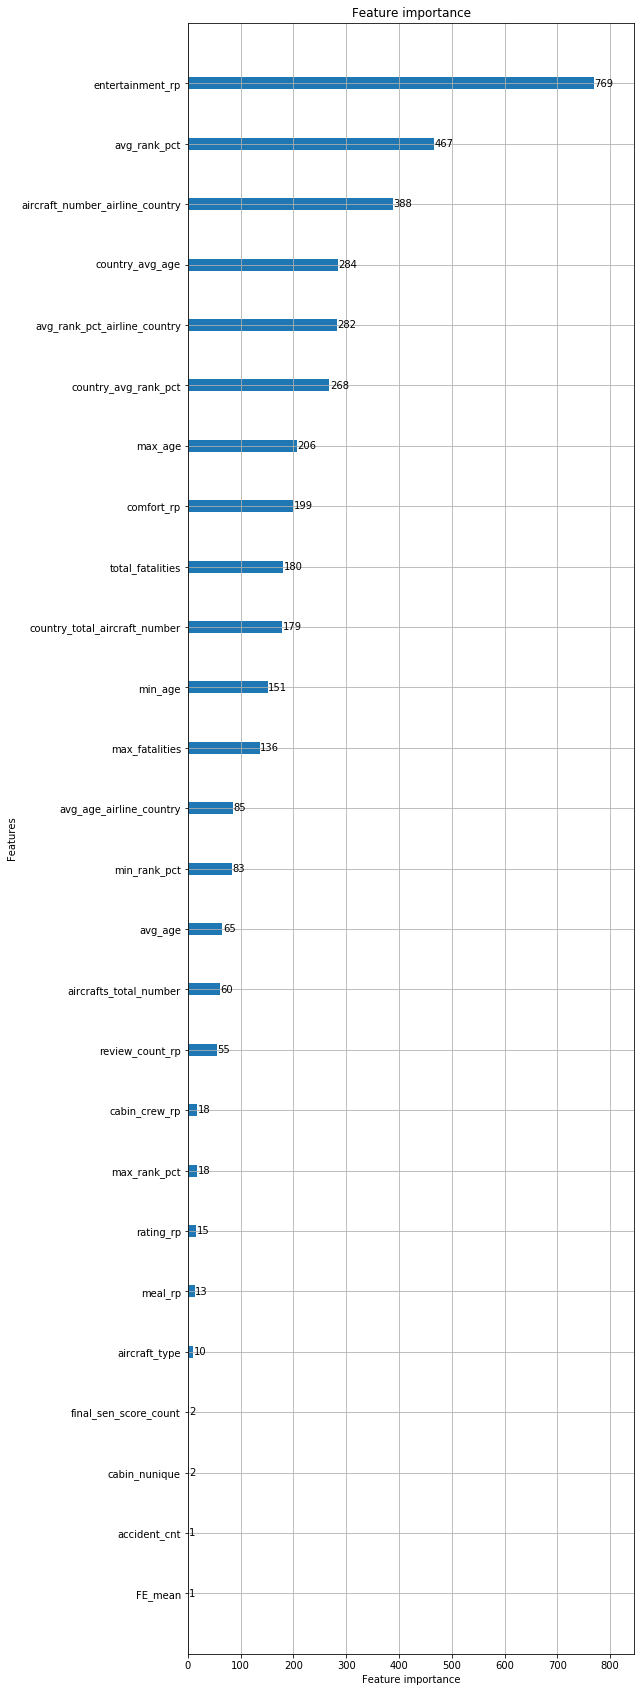

In [56]:
lgb.plot_importance(clf, figsize=(8, 30))

### 画出树的样子

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

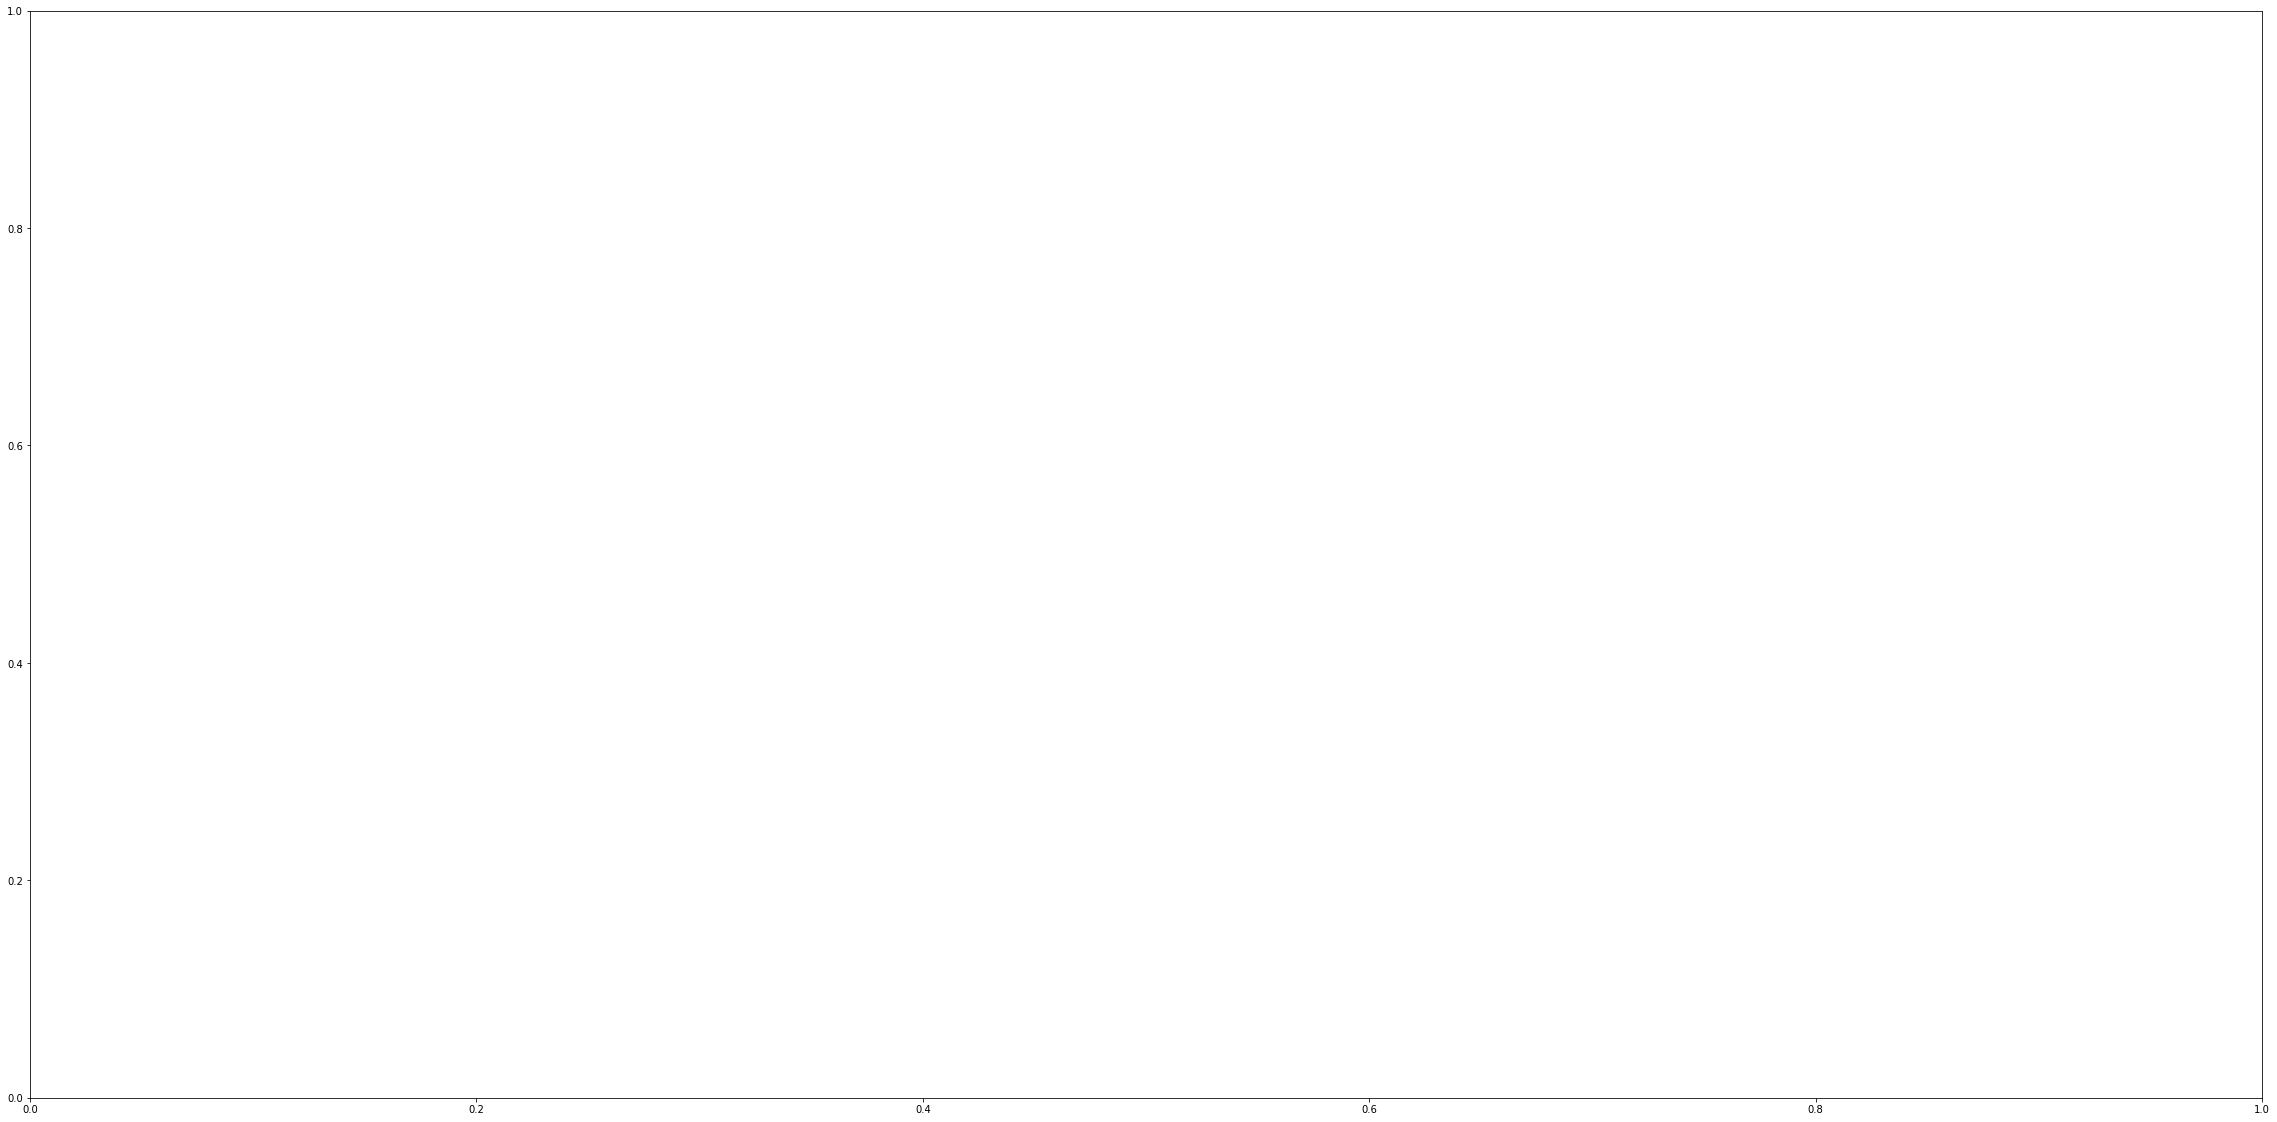

In [57]:
# lgb.plot_tree(clf, figsize=(40, 20))

### 画出每轮迭代中评价指标的变化

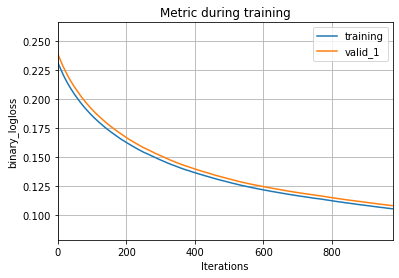

In [58]:
lgb.plot_metric(evals_result, metric='binary_logloss')#metric的值与之前的params里面的值对应

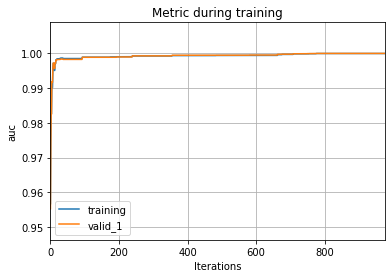

In [59]:
lgb.plot_metric(evals_result, metric='auc')#metric的值与之前的params里面的值对应

### 画ROC曲线

In [60]:
# ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def draw_ROC_curve(y_test,y_predict,savepath=None):
    '''
    画ROC曲线
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
    print(thresholds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    if savepath:
        plt.savefig(savepath)
    plt.close(0)

[1.53476992 0.53476992 0.53469405 ... 0.02836597 0.0283627  0.02831057]


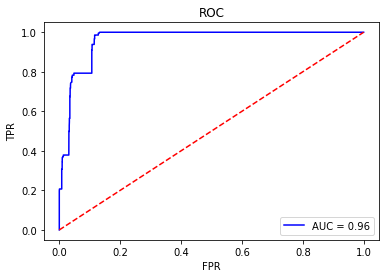

In [61]:
draw_ROC_curve(y_train, oof)

[1.21260801 0.21260801 0.20948183 0.20896938 0.20891291 0.19742103
 0.1945471  0.19404797 0.19399202 0.17762686 0.17757316 0.17709734
 0.17704369 0.17492478 0.17487112 0.17440166 0.17434806 0.1546293
 0.15306692 0.11846169 0.11842692 0.11807546 0.1180408  0.11710871
 0.11706978 0.1093993  0.10560437 0.1055762  0.10359889 0.10326329
 0.10292516 0.10236496 0.10179184 0.10175869 0.0988541  0.09808407
 0.09802018 0.09799401 0.09252257 0.08726075 0.08658014 0.0865562
 0.08376327 0.08374059 0.08183562 0.08181342 0.0798857  0.07986613
 0.0796782  0.07959038 0.07951421 0.0794264  0.07891225 0.07886827
 0.07885025 0.07844933 0.07843143 0.07826573 0.07822272 0.07820511
 0.07487853 0.07407713 0.073999   0.07349394 0.07341374 0.07238113
 0.07191782 0.07145503 0.06959922 0.06804496 0.06730278 0.06698013
 0.06624242 0.06526235 0.06472663 0.06381246 0.06137977 0.06135468
 0.06134441 0.06025905 0.05915374 0.05887066 0.05689475 0.05675503
 0.0567335  0.05672469 0.05668421 0.05666268 0.05662947 0.056558

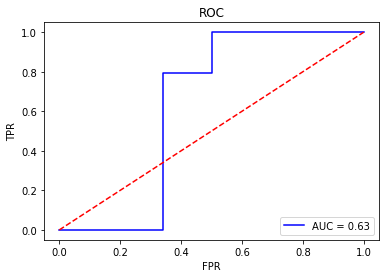

In [62]:
draw_ROC_curve(y_test, predictions)

In [63]:
display(np.max(predictions))
display(np.min(predictions))

0.2126080054928336

0.05095910016133992

In [64]:
display(np.max(oof))
display(np.min(oof))

0.5347699172111539

0.02831056869952492

## 查看test的情况

In [65]:
new_test = pd.concat([test['companyName'].reset_index(), pd.Series(predictions, name='pred')], axis=1)
new_test_company = ['Primera Air [no longer operating]', 'Monarch [no longer operating]', 'WOW air [no longer operating]']
new_test = new_test[new_test['companyName'].isin(new_test_company)]

display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']))

,mean,min,max
companyName,,,
Monarch [no longer operating],0.078256,0.078205,0.078266
Primera Air [no longer operating],0.061351,0.061344,0.061380
WOW air [no longer operating],0.078910,0.078850,0.078912


In [66]:
new_test = pd.concat([test['companyName'].reset_index(), pd.Series(predictions, name='pred')], axis=1)

display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']).sort_values('mean', ascending=False))

,mean,min,max
companyName,,,
InselAir,0.210830,0.208913,0.212608
Alliance Airlines,0.209325,0.208913,0.212608
SANSA,0.209157,0.208913,0.209482
PAWA Dominicana [no longer operating],0.194292,0.193992,0.197421
Luxair,0.176215,0.174348,0.177627
Bassaka Air,0.153470,0.153067,0.154629
Evelop,0.118473,0.118041,0.120876
Royal Brunei Airlines,0.117107,0.117070,0.117109
Mauritania Airlines,0.109450,0.109399,0.109500


In [67]:
new_train = pd.concat([train['companyName'].reset_index(), pd.Series(oof, name='pred')], axis=1)

display(new_train.groupby('companyName')['pred'].agg(['mean', 'min', 'max']).sort_values('mean', ascending=False))

,mean,min,max
companyName,,,
Nextjet [no longer operating],0.283997,0.083700,0.499129
LATAM Airlines,0.268286,0.089413,0.526438
Dynamic International Airways,0.265483,0.083700,0.500409
Air Pegasus (no longer operating),0.259679,0.127945,0.502360
DAT Danish Air Transport,0.252651,0.083700,0.500409
Borajet [no longer operating],0.245437,0.083700,0.500409
Safi Airways,0.244208,0.087242,0.502360
LAN Airlines (now LATAM Airlines),0.229394,0.083700,0.505184
Avianca,0.227631,0.089815,0.534694


# 选取top30个特征，再train一个model

In [111]:
top30_feature = feature_importance_df.groupby('feature').agg('mean').sort_values('importance', ascending=False)[:30].index.values
print(top30_feature)

['entertainment_rp' 'country_avg_rank_pct' 'avg_rank_pct_airline_country'
 'aircraft_number_airline_country' 'avg_rank_pct' 'cabin_crew_rp'
 'rating_rp' 'max_age' 'min_age' 'aircrafts_total_number' 'min_rank_pct'
 'max_fatalities' 'country_avg_age' 'country_total_aircraft_number'
 'avg_age_airline_country' 'review_count_rp' 'meal_rp' 'avg_age'
 'max_rank_pct' 'total_fatalities' 'comfort_rp' 'cabin_nunique'
 'aircraft_type' 'accident_cnt' 'FE_max' 'final_sen_score_count'
 'value_for_money_mean' 'final_sen_score_mean' 'final_sen_score_max'
 'recommended_biggest_cat']


In [126]:
param = {
    "boosting": "gbdt",
    'objective':'binary',
    'scale_pos_weight': 15,
    'metric': ('auc', 'binary_logloss'),
    'learning_rate': 0.001,
    'num_leaves': 5,
    'min_data_in_leaf': 500, #120 
    'max_depth': 3,                        
    "feature_fraction": 0.60279441778009675,
    "bagging_freq": 1,  #int(bagging_freq),   #1
    "bagging_fraction": 0.84918097174380245 ,
    "bagging_seed": 11,
    "lambda_l1": 10.0031581969835157,  # 4
    "verbosity": -1,        
}

In [127]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()
evals_result = {}  #记录训练结果所用

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][top30_feature],
                           label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][top30_feature],
                           label=y_train.iloc[val_idx])

    num_round = 20000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    evals_result=evals_result,   #非常重要的参数,一定要明确设置
                    verbose_eval=500,
                    early_stopping_rounds = 200
    )
    
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][top30_feature], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = top30_feature  # features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[top30_feature], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.143804	training's auc: 0.995307	valid_1's binary_logloss: 0.136683	valid_1's auc: 0.99597
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.145614	training's auc: 0.995359	valid_1's binary_logloss: 0.138329	valid_1's auc: 0.996006
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.142049	training's auc: 0.995611	valid_1's binary_logloss: 0.142842	valid_1's auc: 0.99515
[1000]	training's binary_logloss: 0.128742	training's auc: 0.996371	valid_1's binary_logloss: 0.132145	valid_1's auc: 0.99623
Early stopping, best iteration is:
[1152]	training's binary_logloss: 0.126502	training's auc: 0.997797	valid_1's binary_logloss: 0.130396	valid_1's auc: 0.99779
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.139987	training's auc: 0.995273	valid_1's binary_lo

## 画出 feature_importance

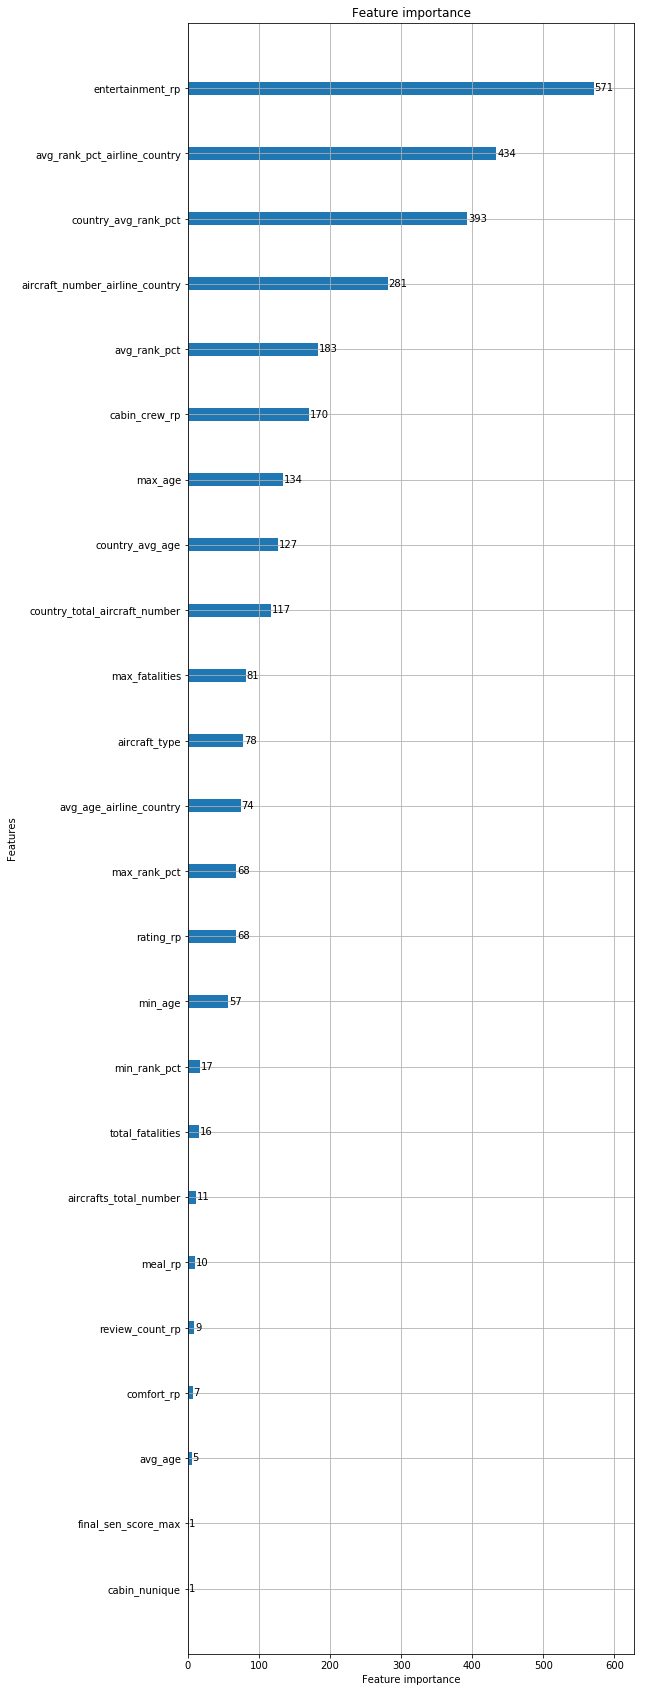

In [128]:
lgb.plot_importance(clf, figsize=(8, 30))

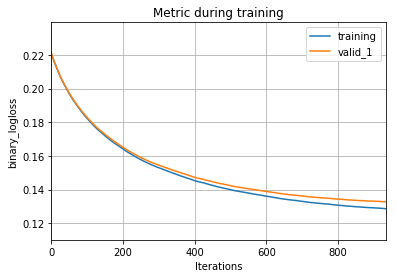

In [129]:
lgb.plot_metric(evals_result, metric='binary_logloss')#metric的值与之前的params里面的值对应

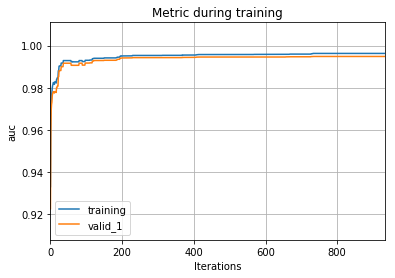

In [130]:
lgb.plot_metric(evals_result, metric='auc')#metric的值与之前的params里面的值对应

## 画出ROC曲线

[ 1.82971465  0.82971465  0.82423283 ...,  0.00911698  0.00886775
  0.00863429]


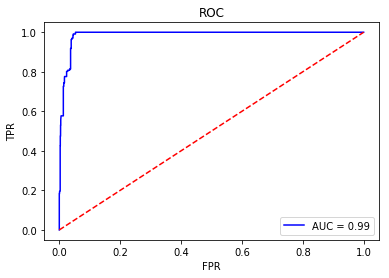

In [131]:
draw_ROC_curve(y_train, oof)  #train

[ 1.55273814  0.55273814  0.54905445  0.54899183  0.54883126  0.53424146
  0.53031474  0.53025169  0.53021148  0.53009087  0.53005066  0.398299
  0.39823598  0.39628233  0.39607192  0.30706604  0.30693624  0.30380107
  0.30374479  0.30367158  0.28441615  0.28418941  0.28079928  0.28075837
  0.2807444   0.28070349  0.28061493  0.28057402  0.23844106  0.2317545
  0.23170399  0.22079444  0.22074652  0.21514477  0.19500873  0.19374341
  0.18168233  0.18151415  0.17909788  0.17905895  0.17903115  0.17895932
  0.17893152  0.17240127  0.17237057  0.16805059  0.16798146  0.16616979
  0.16604153  0.16375118  0.16371374  0.16362415  0.15192668  0.14955075
  0.14948751  0.14944472  0.1494123   0.14155251  0.14106323  0.13921196
  0.13898363  0.13895227  0.13893038  0.13887042  0.11498711  0.11323611
  0.10903177  0.10792137  0.10789689  0.10788237  0.1076101   0.10429835
  0.10427543  0.10426275  0.10421382  0.10252541  0.10241713  0.10213576
  0.1015234   0.10109259  0.10107793  0.10106861  0.10

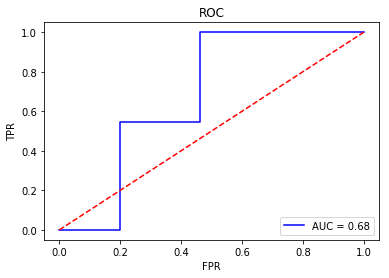

In [132]:
draw_ROC_curve(y_test, predictions)  #test

In [133]:
display(np.max(predictions))
display(np.min(predictions))

0.5527381379541364

0.022410834840906741

In [134]:
np.sort(predictions)[-100:]

array([ 0.53005066,  0.53009087,  0.53009087,  0.53009087,  0.53009087,
        0.53009087,  0.53009087,  0.53009087,  0.53009087,  0.53009087,
        0.53009087,  0.53009087,  0.53009087,  0.53009087,  0.53009087,
        0.53009087,  0.53009087,  0.53009087,  0.53009087,  0.53009087,
        0.53009087,  0.53009087,  0.53009087,  0.53009087,  0.53009087,
        0.53009087,  0.53021148,  0.53021148,  0.53021148,  0.53025169,
        0.53025169,  0.53025169,  0.53025169,  0.53025169,  0.53025169,
        0.53027453,  0.53027453,  0.53027453,  0.53027453,  0.53027453,
        0.53027453,  0.53031474,  0.53031474,  0.53031474,  0.53031474,
        0.53031474,  0.53031474,  0.53031474,  0.53031474,  0.53031474,
        0.53424146,  0.53424146,  0.53424146,  0.53424146,  0.53424146,
        0.53424146,  0.53424146,  0.53424146,  0.53424146,  0.53424146,
        0.53424146,  0.53424146,  0.53424146,  0.53424146,  0.53424146,
        0.53424146,  0.53424146,  0.53424146,  0.53424146,  0.53

In [135]:
np.sort(oof)[-500:]

array([ 0.60376583,  0.60376583,  0.60376583,  0.60376583,  0.60376583,
        0.61084039,  0.61084039,  0.61084039,  0.61489098,  0.61489098,
        0.61489098,  0.61489098,  0.61489098,  0.61860312,  0.61860312,
        0.62262283,  0.62262283,  0.62295916,  0.62295916,  0.62295916,
        0.62295916,  0.62295916,  0.63062633,  0.63062633,  0.63062633,
        0.63062633,  0.63063773,  0.63063773,  0.63063773,  0.63063773,
        0.63063773,  0.63063773,  0.63063773,  0.63063773,  0.63063773,
        0.63063773,  0.63063773,  0.63063773,  0.63063773,  0.63105438,
        0.63105438,  0.63105438,  0.63105438,  0.63105438,  0.63105438,
        0.63105438,  0.63105438,  0.63105438,  0.63105438,  0.63105438,
        0.63105438,  0.63105438,  0.63105438,  0.63105438,  0.63105438,
        0.63712855,  0.63712855,  0.63733625,  0.63733625,  0.63733625,
        0.63733625,  0.63733625,  0.64162991,  0.64162991,  0.64162991,
        0.64183648,  0.64183648,  0.64183648,  0.64338466,  0.64

## 查看test中

In [136]:
new_test = pd.concat([test['companyName'].reset_index(), pd.Series(predictions, name='pred')], axis=1)
new_test_company = ['Gulf Air', 'Monarch [no longer operating]', 'WOW air [no longer operating]']
new_test = new_test[new_test['companyName'].isin(new_test_company)]

display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']))

,mean,min,max
companyName,,,
Gulf Air,0.061050,0.061050,0.061050
Monarch [no longer operating],0.167981,0.167981,0.167981
WOW air [no longer operating],0.168051,0.168051,0.168051
